
# Identifying Science Fiction Sub-Genres with NLP
### Andrew Mooney

![Sci-fi scape](images/sci_fi_scape.jpeg)

## Introduction - How to Get Published

As a writer who has always dreamed of being published, one of the greatest challenges I have faced is coming to terms with the professional world of being an author. People don't get published simply because their work is 'good'. Harry Potter famously had trouble finding a publisher back in the day. To become a professional writer, one must not only write something good, but you must also navigate the tumultuous world of literary agents and publishers with budgets and deadlines. 

This can all seem intimidating, and, quite frankly, that's because it is. It is also a massive hinderance to the next generation of writers who might not have masters degrees from Iowa State. We are also at a tipping point in the writing industry with the advent of publishers like Amazon who seek to change the publishing landscape. There are so many routes to take and none of them are 'correct', but some are better traversed than others and provide a little more guidance.

In science fiction, there are niche markets and mass markets, schlock and award winners. There are the books that get developed into HBO shows and long-running series that create more pulp than the entire legal industry combined. The one thing that is true for MOST books is that they have a literary agent. There are many, many resources explaining why literary agents are useful, not the least of which it's their entire job to get you published and they work solely on commission. So, how do you get one of these magical agents? Here is a quick check list:

- Write a fantastic query letter with a compelling plot description
- Associate your book with other successful books in the industry
- Make sure your writing sample is rock solid

Oh yes, and one small thing:

- FIND THE RIGHT AGENTS

This last one is a real doozy. Do you know how many literary agents there are out there? Neither do I, but there are a lot. Some are experienced and conservative, some are fresh and bold, but all are worthy of your research. The first thing to do is identify what kind of book you have written. Yes, we all like to say our books are special and unique, and that is predominantly true, but where does it fit in the literary landscape? Identifying what books are similar helps complete two objectives: first, it helps guide you as to where your book fits in and what other authors similar to you and, second, if a book is fairly similar, perhaps you should send a query to that book's agent. It couldn't hurt!

![Retro](images/science_fiction_retro.jpeg)

### Objective

The purpose of this project was to build a tool that helps new authors attempt to break into the publishing industry. Due to the narrow (but deep) nature of my dataset, I built the model solely on Science Fiction novels, but I hope to expand its scope in the future to encompass Romance, Thrillers, Fantasy and, (gulp) maybe even general Fiction. Using Natural Language Processing, this tool will take in a book description (similar to a blurb on a book jacket) and tell you three key things:

- What subgenres does your story fall under?
- What age group does it seem appropriate for?
- What are the 10 most similar books currently on the market?

This Jupyter Notebook will take you through how I built and tuned my model as well as some examples on three book descriptions of novels I have written and (unsuccessfully) attempted to publish via the agent search.

### Use Cases

Who is this for? Well, if you're interested in Natural Language Processing, I have built two classes housed in my utils file that I use for processing and testing models in only a couple of lines of code. Feel free to use and improve on them because they made this project shockingly swift (even if the processing time leaves a little to be desired). Secondly, if you are an author who has written at least a good chunk of a novel and you're hoping to start the publishing journey, here is the process I recommend:

- Write a plot summary in the same style as a book jacket blurb - follow examples of books you love
- Feed the summary into the processing tool
- Make sure that the appropriate genres and age groups show up - if they don't, use the most important words list to identify which words contributed to your scores
- Find the ten most similar novels to yours that were released in the last 10 years. Use those books in both your query letter (if they were moderately successful releases) and also use them to identify possible literary agents to submit your work to.

Okay, let's talk about how it all works.

## The Data

I used the [Science Fiction Books Kaggle dataset](https://www.kaggle.com/tanguypledel/science-fiction-books-subgenres)  of 11000 science fiction novels pulled from the Goodreads API. All of which came with several key data points: novel description, year published, Goodreads review/score numbers, and genre tags. The creator of the dataset originally pulled the top 1250 books in each of 12 major subgenres...however, that organization into genres was not necessarily useful. For example, a book that might be a popular cyberpunk book could also be a military story, but it is much better known for being cyberpunk. Therefore, it might show up on the cyberpunk list and not at all on the military one.

Instead, I used the user-generated genre tags pulled from Goodreads to get a stronger understanding of what genre each novel fits into. This creates a Multi-Label Classification problem. Any novel can be in multiple subgenres (just look at *Hitchhiker's Guide to the Galaxy*!) so the model needed to be able to assign multiple labels to each description. As for sorting into age groups, that is a Multi-Class Classification, much simpler and clearer-cut.

My original plan was to enrich this dataset with other novels from Goodreads...however the Goodreads API is no longer available to new users, so any future expansion of this project will require other avenues.

### Data Loading and Cleaning

Let's import and start playing with book descriptions!

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix, hamming_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm
from utils import process_text, TextSet, ModelComparison, age_group, find_genre, genre_process
import matplotlib.pyplot as plt
import spacy
import time
import warnings
warnings.filterwarnings('ignore')

Below you can see each dataset of books loaded in and then combined into one large dataset with duplicate novels removed

In [2]:
df_aliens = pd.read_csv('data/sf_aliens.csv')
df_aliens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1250 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1249 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [3]:
df_alt = pd.read_csv('data/sf_alternate_history.csv')
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1249 non-null   object 
 1   Original_Book_Title  1249 non-null   object 
 2   Author_Name          1249 non-null   object 
 3   Edition_Language     1248 non-null   object 
 4   Rating_score         1249 non-null   float64
 5   Rating_votes         1249 non-null   int64  
 6   Review_number        1249 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1249 non-null   int64  
 9   Genres               1249 non-null   object 
 10  url                  1249 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [4]:
df_alt_u = pd.read_csv('data/sf_alternate_universe.csv')
df_alt_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1247 non-null   object 
 1   Original_Book_Title  1247 non-null   object 
 2   Author_Name          1247 non-null   object 
 3   Edition_Language     1246 non-null   object 
 4   Rating_score         1247 non-null   float64
 5   Rating_votes         1247 non-null   int64  
 6   Review_number        1247 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1247 non-null   int64  
 9   Genres               1247 non-null   object 
 10  url                  1247 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.3+ KB


In [5]:
df_app = pd.read_csv('data/sf_apocalyptic.csv')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1244 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [6]:
df_cyber = pd.read_csv('data/sf_cyberpunk.csv')
df_cyber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1244 non-null   object 
 1   Original_Book_Title  1244 non-null   object 
 2   Author_Name          1244 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1244 non-null   float64
 5   Rating_votes         1244 non-null   int64  
 6   Review_number        1244 non-null   int64  
 7   Book_Description     1226 non-null   object 
 8   Year_published       1244 non-null   int64  
 9   Genres               1244 non-null   object 
 10  url                  1244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.0+ KB


In [7]:
df_dys = pd.read_csv('data/sf_dystopia.csv')
df_dys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1242 non-null   object 
 1   Original_Book_Title  1242 non-null   object 
 2   Author_Name          1242 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1242 non-null   float64
 5   Rating_votes         1242 non-null   int64  
 6   Review_number        1242 non-null   int64  
 7   Book_Description     1241 non-null   object 
 8   Year_published       1242 non-null   int64  
 9   Genres               1242 non-null   object 
 10  url                  1242 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 106.9+ KB


In [8]:
df_hard = pd.read_csv('data/sf_hard.csv')
df_hard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1246 non-null   object 
 1   Original_Book_Title  1246 non-null   object 
 2   Author_Name          1246 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1246 non-null   float64
 5   Rating_votes         1246 non-null   int64  
 6   Review_number        1246 non-null   int64  
 7   Book_Description     1219 non-null   object 
 8   Year_published       1246 non-null   int64  
 9   Genres               1246 non-null   object 
 10  url                  1246 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.2+ KB


In [9]:
df_mil = pd.read_csv('data/sf_military.csv')
df_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1249 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [10]:
df_rob = pd.read_csv('data/sf_robots.csv')
df_rob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1239 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [11]:
df_space = pd.read_csv('data/sf_space_opera.csv')
df_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [12]:
df_steam = pd.read_csv('data/sf_steampunk.csv')
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1249 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1246 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [13]:
df_time = pd.read_csv('data/sf_time_travel.csv')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1244 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


Here is a quick view of one of the datasets. Notice that the Book Title would be considered the common title of the book while the 'Original_Book_Title' is sometimes a title used on the professional/publisher side.

In [14]:
df_aliens.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal


## Data Exploration

Below you will see my first attempt to label each of the books. As I noted above, this was not the final approach that I took, but it's helpful to see the 12 categories that were original sourced from Goodreads. 

In [15]:
# Creates a combined dataset of all books, with any entry that has a duplicate of both a book title and author 
# name getting dropped

genre_list = [
    'aliens',
    'alternate_history',
    'alternate_universe',
    'apocalyptic',
    'cyberpunk',
    'dystopia',
    'hard',
    'military',
    'robots',
    'space_opera',
    'steampunk',
    'time_travel'
]

df_list = []

for genre in genre_list:
    df = pd.read_csv(f'data/sf_{genre}.csv')
    df.drop_duplicates(subset=['Book_Title','Author_Name'],inplace=True)
    df[f'{genre}'] = 1
    df_list.append(df)

df_books = pd.concat(df_list)

In [16]:
# Creates the original multi-label table based on the 12 genres listed above. 
# Again, this was not used in the final model
genre_score = df_books[['Book_Title','Author_Name'] + [genre for genre in genre_list]].groupby(['Book_Title','Author_Name']).sum()
df_books = df_books.drop(columns=[genre for genre in genre_list]).drop_duplicates(subset=['Book_Title','Author_Name'])

This dataframe below will be the core dataframe for the project. As I mentioned, it only has books that Goodreads considers Science Fiction, some of which are dubious choices. There are also a number of short story collections and self-published books that we will filter out when we consider both how recent the texts should be and how popular they should be. Nobody wants to say their novel is similar to a flop.

In [17]:
df_desc = df_books.merge(genre_score, how='inner', on=['Book_Title','Author_Name'])
df_desc = df_desc.dropna(subset=['Book_Description']) # I dropped all rows that didn't include a description

Ultimately, we have 11025 distinct books with a WIDE variety of scores, reviews and years published. As we'll see in a moment, the books skew modern, while a mean of 2001 but a median of 2012. This is a positive thing because we want as much of our sample to be relevant to contemporary publishing trends.

In [18]:
df_desc.describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel
count,11025.000000,1.102500e+04,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000
mean,3.923708,2.529002e+04,1355.155193,2001.996825,0.113197,0.113107,0.113107,0.112834,0.111111,0.112562,0.110385,0.113288,0.112200,0.111837,0.113016,0.113016
std,0.296662,1.684630e+05,5403.296914,100.414819,0.316848,0.316737,0.316737,0.316405,0.314284,0.316071,0.313384,0.316959,0.315626,0.315180,0.316627,0.316627
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.730000,6.620000e+02,55.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.930000,2.037000e+03,163.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.130000,7.387000e+03,597.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,7.336299e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11094
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           11025 non-null  object 
 1   Original_Book_Title  11025 non-null  object 
 2   Author_Name          11025 non-null  object 
 3   Edition_Language     11000 non-null  object 
 4   Rating_score         11025 non-null  float64
 5   Rating_votes         11025 non-null  int64  
 6   Review_number        11025 non-null  int64  
 7   Book_Description     11025 non-null  object 
 8   Year_published       11025 non-null  int64  
 9   Genres               11025 non-null  object 
 10  url                  11025 non-null  object 
 11  aliens               11025 non-null  float64
 12  alternate_history    11025 non-null  float64
 13  alternate_universe   11025 non-null  float64
 14  apocalyptic          11025 non-null  float64
 15  cyberpunk            11025 non-null 

Now that we have a basic idea of our meta-data, let's drill into the descriptions. The first visualizations I find helpful are wordclouds and frequency distributions. Below you will see both, the first frequency distribution contains stop words and core words.

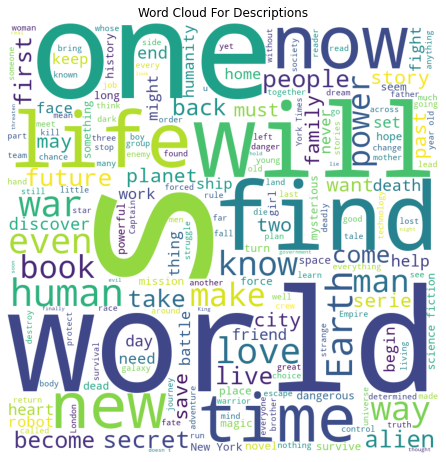

In [20]:
words = ' '.join(list(df_desc['Book_Description']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(f'Word Cloud For Descriptions')
plt.show()

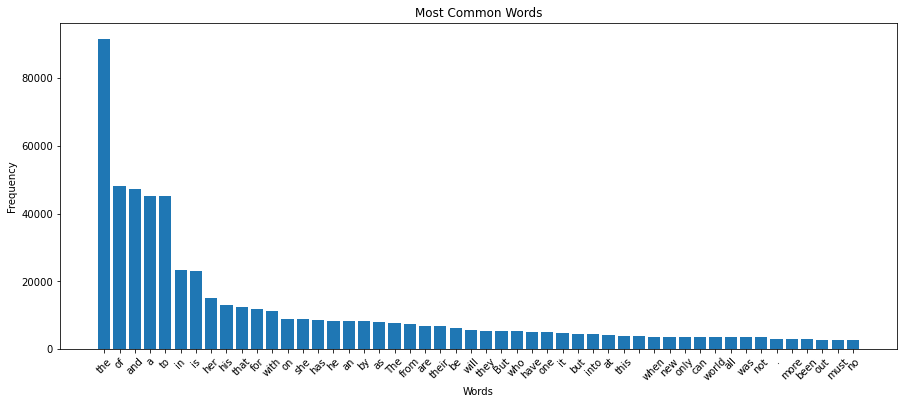

In [21]:
words = ' '.join(list(df_desc['Book_Description']))
tokens = words.split(' ')

data_freqdist = FreqDist(tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

As with any NLP project, removing stop words is essential to analysis. I used the basic stop word dictionary from the Natural Language Tool Kit from Sklearn and added a few unique symbols that tended to muddy the data.

In [22]:
stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/', 's', "'s", "n't",'’s','n’t','','-','.']

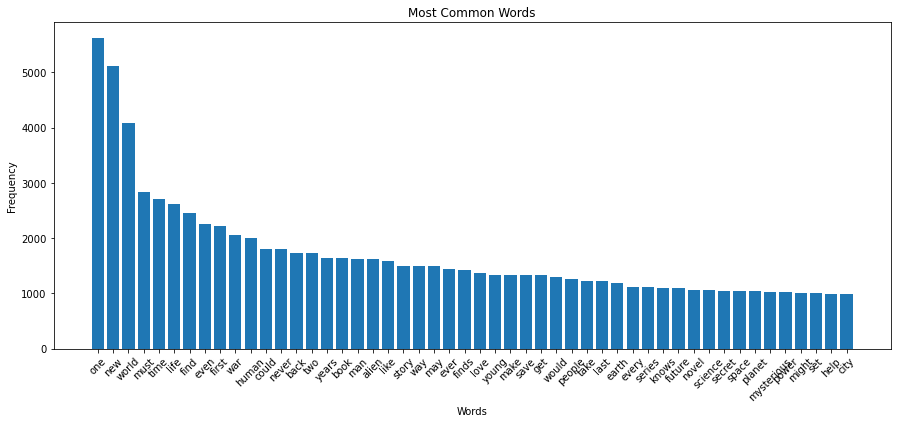

In [23]:
# Second frequency distribution, but with no stop words.
clean_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]

data_freqdist = FreqDist(clean_tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

Already we can see that this is definitely a collection of science fiction stories. 'New', 'world', 'time', 'war', 'human', and 'alien' are key words in science fiction storytelling. Based on the first 50 words in the distribution, this feels like enough stopword preprocessing to start.

Let's have a look at the reviews, votes and years published to note any outliers.

In [24]:
df_desc['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [25]:
df_desc['Rating_votes'].describe()

count    1.102500e+04
mean     2.529002e+04
std      1.684630e+05
min      0.000000e+00
25%      6.620000e+02
50%      2.037000e+03
75%      7.387000e+03
max      7.336299e+06
Name: Rating_votes, dtype: float64

In [27]:
# Randomly selects a portion of the book descriptions
test_df = df_pop.sample(n=15, random_state=42)
str(test_df['Book_Description'])

'2486     Narnia… the land beyond the wardrobe door, a s...\n2990     The breakout hit of the biggest Spider-Event o...\n3547     A penetrating, page-turning tour of a post-hum...\n318      When a massive object crashes into the ocean o...\n1703     This is the world. It is not the one we wanted...\n697      As far as job hazards go, Douglass Fraser didn...\n7579     Far in the future, 60,000 light-years from Ear...\n2730     A masterful tale of ambition, jealousy, desire...\n2267     Presenting for the first time the adventures o...\n2953     Rebel by chance. Traitor by choice.Gunslinger ...\n8361     Listening Length: 5 hours and 18 minutesA capt...\n5197     Iko – an audacious android and best friend to ...\n3354     When all else comes to naught, a steadfast hea...\n10305    When Nigel Walden is fourteen, the unhappening...\n10576    In this stunning, imaginative novel, Eve Marie...\nName: Book_Description, dtype: object'

![Typewriter](images/typewriter_2.jpg)

## Descriptions - Pre-Processed Before NLP

One of the strengths of this project is based on the similarity of the style of each book description. When analyzing comments on the internet or on twitter, there is little to no rhyme or reason to how people type. Some tweets can be riddled with urls or typos, increasing the sample noise. However, for this project, each book description is connected with a published book. That means this blurb has very likely passed through the hands of a marketing team who has a certain style and way of approaching the market. These descriptions were not written by amateur authors, but rather professionals and therefore they all have a similarity in style and a baseline of quality.

In [28]:
test_df['Book_Description'].iloc[2]

"A penetrating, page-turning tour of a post-human EarthIn The World Without Us, Alan Weisman offers an utterly original approach to questions of humanity's impact on the planet: he asks us to envision our Earth, without us. In this far-reaching narrative, Weisman explains how our massive infrastructure would collapse and finally vanish without human presence; which everyday items may become immortalized as fossils; how copper pipes and wiring would be crushed into mere seams of reddish rock; why some of our earliest buildings might be the last architecture left; and how plastic, bronze sculpture, radio waves, and some man-made molecules may be our most lasting gifts to the universe.The World Without Us reveals how, just days after humans disappear, floods in New York's subways would start eroding the city's foundations, and how, as the world's cities crumble, asphalt jungles would give way to real ones. It describes the distinct ways that organic and chemically treated farms would reve

Now let's see how the year distribution breaks down.

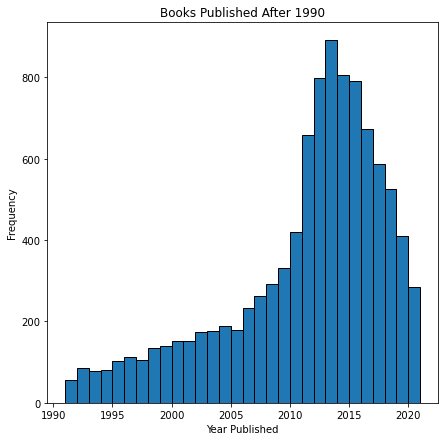

In [29]:
# Plots only the novels that were published after 1990
x = df_desc[df_desc['Year_published'] > 1990]['Year_published']
plt.figure(figsize=(7,7))
plt.hist(x=x, bins=30, edgecolor='black')
plt.title('Books Published After 1990')
plt.ylabel('Frequency')
plt.xlabel('Year Published')
plt.show()

As we can see, the novels skew modern, which is a good thing. Also, it's important to note that the books on Goodreads are frequently for editions currently on the market. The author doesn't write the book blurb, the current publisher's marketing team does. Therefore, while the subject matter of the older stories might skew into different themes, the blurb style is still similar and contemporary.

Let's continue processing the data to get it ready for modeling. First, we need to extract the genres provided by Goodreads to create our target columns. I created a simple function for the dataframe that can be found in the utils file.

In [30]:
# Adds a 'genres' column which is a list of genres from Goodreads
df_desc['genres'] = df_desc['Genres'].map(lambda x: find_genre(x))

First we are going to assign the age group. To do this I created another quick function that's in the utils file. While some books could be classified in multiple ways, I rounded down. If a book is child appropriate, then it's 'Children'. If it was labeled 'Young Adult' and wasn't labeled 'Children', it returns 'Young Adult'. 'Adult' is the default return.

This is how each category breaks down:

In [31]:
# Creates the Age Group target column
df_desc['Age_Group'] = df_desc['Genres'].map(lambda x: age_group(x))

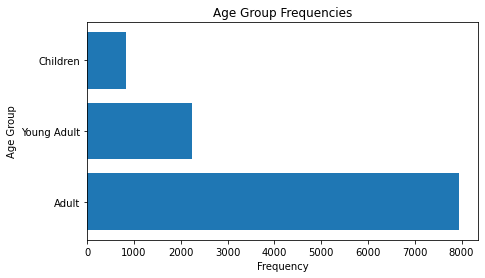

In [46]:
# Plots the Age Groups for comparison
x = list(dict(df_desc['Age_Group'].value_counts()).keys())
y = list(dict(df_desc['Age_Group'].value_counts()).values())

plt.figure(figsize=(7,4))
plt.barh(y=x, width=y)
plt.title('Age Group Frequencies')
plt.ylabel('Age Group')
plt.xlabel('Frequency')
plt.show()

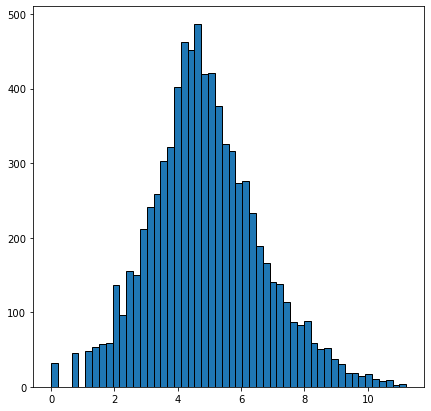

In [33]:
# A log transformation of the review number of all adult novels. It follows a moderately normal distribution
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

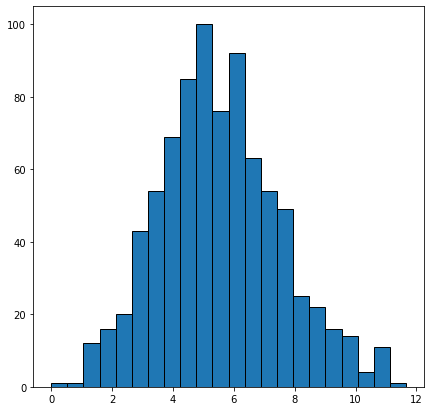

In [34]:
# Same thing, but for Children's/Middle Grade books
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Children']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

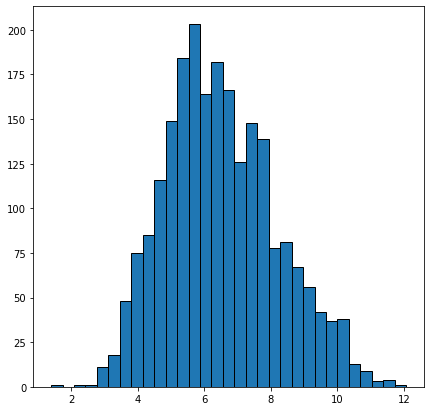

In [35]:
# And finally for young adult. All of them looked fairly normal.
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Young Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

## Text Processing

There are multiple ways to process text in Natural Language Processing. For each model, I decided to try multiple methods of vectorization. In my TextSet class we can set the processing parameters and then my ModelComparison class allows me to evaluate the performance of each processing method against one another. Here are the three methods that I will explore:

### SpaCy

SpaCy is (as of this writing) a newer NLP toolset that has its own pretrained library based on 100 million Wikipedia articles. SpaCy has a number of impressive inherent features such as a pipeline that can identify Proper Nouns in sentences as well as attaching parts of speech to words. It is also a powerful tokenizer that will automatically lemmatize words. SpaCy also has a doc2vec vectorization method that I will be using. Without removing stopwords and punctuation, SpaCy can turn paragraphs into vectors fairly quickly. 

In my experience, the doc2vec method has produced lackluster results, but I'm not 100% sure I'm using the vectorization method in the best way.

### Count Vectorization/Bag of Words

The second method is simply count vectorization. This means we find the most common words in the entire corpus of the book descriptions, remove all stop words, and then vectorize based on the frequency of each of those common words in each description. We saw 'human' and 'war' are two of the most common words in the dataset. If description A has 2 'human' mentions and 0 'war' mentions, the vector would be:

        [2, 0]

And if description B had 1 'human' mention and 3 'war' mentions, its vector would look like:

        [1, 3]

Unfortunately, this method was also fairly inaccurate ultimately. I did, however, save the best 'til last:

### TF-IDF Vectorization

This is, hands-down, my favorite vectorization method available. Similar to the count vectorization method, Term Frequency-Inverse Document Frequency (TF-IDF) vectorization wants to know two things: how many common words are in each document AND are there certain documents where those words DON'T show up. Think about a hard science description versus a romantic space opera. The space opera would have far more heroic, epic words while the hard science one might have words like 'science' and 'experiment' etc. Already you get a stronger picture of the genre or age group by knowing both dimensions. This method is far more effective in text classifcation in the two projects I've completed with NLP.

TF-IDF can also be tweaked with how many common words do we want to track as well as increasing the n-gram range. Sometimes words are more common in pairs than alone. For example, the word opera is probably not going to show up without 'space' in front of it. I will be exploring multiple vectorization methods using these parameters.

Let's start the vectorization process!

In [36]:
nlp = spacy.load("en_core_web_sm") #Loads SpaCy, an essential library for tokenization

In [37]:
# The SpaCy dataset, includes stop words.
spacy_1 = TextSet(X=df_desc['Book_Description'], # The processing column is the book description
                  y=df_desc['Age_Group'], # The Target column is the Age Group. TextSet will label encode the target for us
                  name = 'SpaCy 1',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42)

--- 632.5671212673187 seconds ---


In [38]:
# The first of 3 TF-IDF processing methods. This one will have 400 features and will read phrases 1-2 words long
tf_idf_400_2 = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_400_2',
                 is_spacy=False, # Stop words are removed with TF-IDF
                 keep_stopwords=False)

--- 638.6462409496307 seconds ---


In [39]:
# Second TF-IDF - this one will only look at single words but will not be bounded in the number of most common words to vectorize
tf_idf_None = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_None',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 641.4852359294891 seconds ---


In [40]:
# The last TF-IDF method - 400 words will be measured, but only one word, not 1-2
tf_idf_400_1 = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_400_1',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 643.9909110069275 seconds ---


As you can see, the word clouds for each dataset is similar, but slightly different.

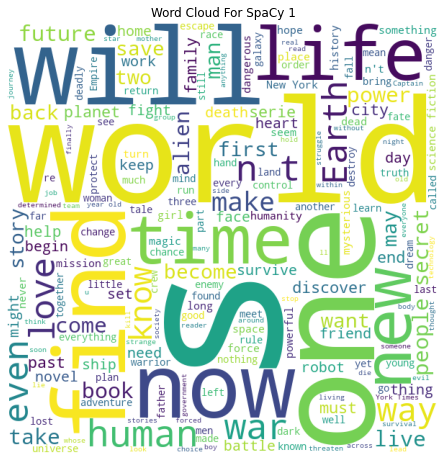

In [41]:
spacy_1.word_cloud()

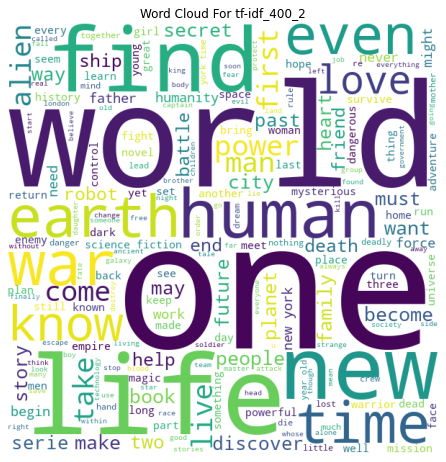

In [42]:
tf_idf_400_2.word_cloud()

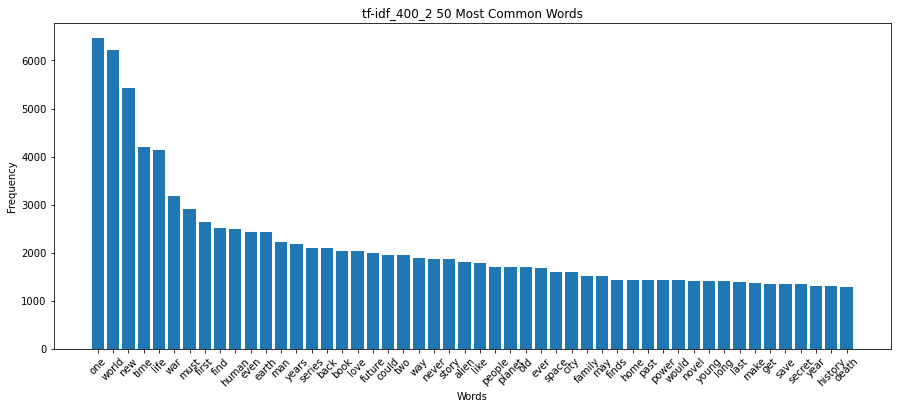

In [43]:
tf_idf_400_2.plot_frequency()

In [44]:
# Vectorizes each dataset based on the parameters required to test the different number of features and ngram range
spacy_1.vectorize()
tf_idf_400_2.vectorize(max_features=400, ngram_range=(1,2))
tf_idf_None.vectorize(max_features=None)
tf_idf_400_1.vectorize(max_features=400)

In [45]:
# Creates the data list for processing
data = [spacy_1, tf_idf_400_2, tf_idf_None, tf_idf_400_1]

## Model 1 - Age Group

The first model that I built predicts the age group that would be the novel's target audience. As I mentioned above, this is a multi-class classification, not a multi-label one. As you can see, the majority class (adult) of the dataset is 72% of the values, meaning that our model has to have an accuracy of higher than 72% to be considered effective.

In [46]:
df_desc['Age_Group'].value_counts(normalize=True)

Adult          0.721179
Young Adult    0.203719
Children       0.075102
Name: Age_Group, dtype: float64

In [ ]:
df_desc['Age_Group']

While I did try a few modeling methods, I have found that the Support Vector Machine classifier has the best results on text classification. Below, you can see commented-out code for a GridSearch, which I used to find out the ideal parameters for the model. However, running it sometimes crashed my laptop. To avoid this, I have filled in the final parameters of the best model already and I ran those without the gridsearch included.

The ModelComparison class object takes in the datasets that we have already vectorized and trains the model on each of the datasets in turn (returning the length of time it took to process each one as well). It produces results for each dataset in turn and can also show confusion squares on multi-class and binary classification problems.

In [47]:
# The Support Vector Machine model for Age Group classification.
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC(kernel='rbf',gamma='scale',C=1e12,decision_function_shape='ovr'))])

# grid= {
#     'rbf__kernel':['rbf', 'sigmoid'],
#     'rbf__gamma' :['scale','auto'],
#     'rbf__C': [1, 100, 1e12],
#     'rbf__decision_function_shape': ['ovo','ovr']
# }

# svm_grid = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy',cv=5)
svm_compare = ModelComparison(pipeline=svm_pipe, data_list=data, y_format='label',name='svm')

In [48]:
svm_compare.fit_models()
svm_compare.score_comparison

SpaCy 1 finished in 10.01484990119934 seconds
tf-idf_400_2 finished in 30.09706687927246 seconds
tf-idf_None finished in 4734.208377122879 seconds
tf-idf_400_1 finished in 32.30858397483826 seconds
--- 4807.374222278595 seconds to process ---


,SpaCy 1 Test,tf-idf_400_2 Test,tf-idf_None Test,tf-idf_400_1 Test
Accuracy,0.704064,0.773933,0.765536,0.769903
Precision (Macro),0.493747,0.697084,0.857003,0.676301
Recall (Macro),0.439075,0.520615,0.447846,0.510562
F1 (Macro),0.451899,0.560019,0.479466,0.547340


### Observations

As we can see, the TF-IDF Vectorization dataset with 400 words considered and a word length of 1 or 2 words long was the most accurate model with an accuracy of 77.4%, precision of 69% and recall of 52%. When performing my gridsearches, I optimized my accuracy, which counts how often the model guessed correctly. Interestingly, the dataset with the most columns (TF-IDF None) had poorer accuracy but much higher precision than the other models. It also took 142 times longer to finish fitting the data.

**Precision** measures the chance that if you guess something is a class, how often you are correct, while **Recall** measures how often you say it ISN'T a class and how often your guess is correct. **F1 Scores** are a balance between precision and recall. We would like to see a balance in all four scores which is why they are included. The TF-IDF_400_2 dataset has the best scores in everything other than Precision.

If we want to see these scores visualized, here's the Confusion Matrix of each dataset. For Confusion Matrices, we always want the top left to bottom right diagonal to have the highest values because that is where the model predicted the correct labels. As you can see, the model really tries to guess the majority class more often than not, which is absolutely sensible. That said, the TF-IDF_400_2 has a decent balance between false positives and false negatives.

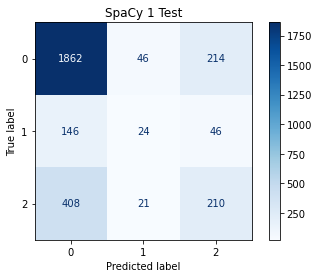

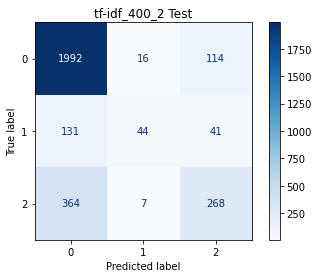

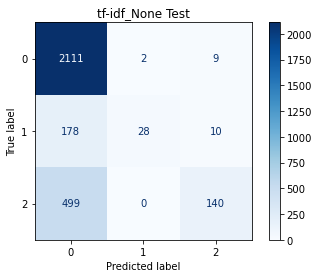

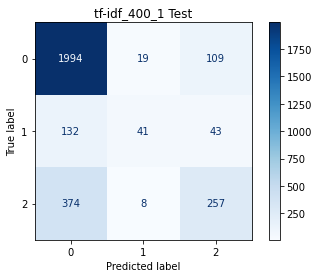

In [49]:
svm_compare.compare_confusion()

#### What does 'good' look like?

Remember, this isn't supposed to be a black box algorithm, meaning that, in the end, I want the user to be able to see *why* their description returned certain scores. This means that we might not care as much about correctly predicting the age group, but rather ranking the probabilities of each genre. That way, when you tweak your description, you can see those probabilities increase or decrease.

Also, those scores are the *test* results. Let's see how we did on the *holdout* dataset.

In [50]:
svm_compare.calc_scores(data_type='holdout') # Recalculates the scoring with the holdout dataset
svm_compare.score_comparison

,SpaCy 1 Holdout,tf-idf_400_2 Holdout,tf-idf_None Holdout,tf-idf_400_1 Holdout
Accuracy,0.699909,0.783318,0.763373,0.778785
Precision (Macro),0.506496,0.734752,0.834976,0.740954
Recall (Macro),0.434593,0.535429,0.445494,0.535530
F1 (Macro),0.449797,0.583244,0.476560,0.585351


Once again TF-IDF_400_2 did better than the other datsets. This time, interesting, the holdout dataset has better scores than the testing dataset, which leads me to believe that the model is underfit or there is too much noise in the main testing data. In any case, TF-IDF_400_2 is the way to go.

Now, we need to isolate a few things. First we need to train the model on the best dataset (the ModelComparison object trains the models on sequential datasets, so it's always left trained on the final dataset), then we need to save the **trained model** and, crucially, the **text vectorizer**

In [51]:
# This is the same model, simply run on the main dataset
svm_pipe = Pipeline([('scaler', StandardScaler(with_mean=False)), ('rbf',svm.SVC(kernel='rbf',gamma='scale',C=1e12,decision_function_shape='ovr',probability=True))])
svm_compare = ModelComparison(pipeline=svm_pipe, data_list=[tf_idf_400_2], y_format='label',name='svm')
svm_compare.fit_models()
svm_compare.score_comparison

tf-idf_400_2 finished in 85.00200486183167 seconds
--- 85.01161694526672 seconds to process ---


,tf-idf_400_2 Test
Accuracy,0.774269
Precision (Macro),0.697872
Recall (Macro),0.521137
F1 (Macro),0.560647


In [52]:
svm_compare.all_scores

,tf-idf_400_2 Train,tf-idf_400_2 Test
Accuracy,0.998848,0.774269
Precision (Macro),0.999472,0.697872
Recall (Macro),0.998061,0.521137
F1 (Macro),0.998763,0.560647


In [53]:
# Saves the age model and the vectorizer for later.
age_model = svm_compare.pipeline
age_vectorizer = tf_idf_400_2.vectorizer

In [54]:
age_model_2 = svm_compare.pipeline

And now we have our Age Model ready to go and our vectorizer to create a processing pipeline!

![Planet Ring](images/planet_ring.jpeg)

## Model 2 - Genre Prediction

As I have stated, the genre prediction is a much more complicated challenge compared to the multi-class classification of age identification. For Genre we have to do some more preprocessing once more.

When we bypassed the genre groupings suggested by the dataset, we pulled in every tag assigned to each book. As far as I understand it, Goodreads allows users to tag a book with a genre, offering hundreds of sub and sub sub genres to pick from. This is both wonderful, because humans did a lot of our hard work for us, and annoying, because the data is *really* messy. To create an exhaustive list of the possible genre tags I used the following function:

In [55]:
genre_dict = {}

def generate_genre_dict(x):
    
    for genre in x:
        if genre in genre_dict.keys():
            genre_dict[genre] += 1
        else:
            genre_dict[genre] = 0

When applied to the dataframe, it returns nothing but builds our genre dictionary for us:

In [56]:
df_desc['genres'].map(lambda x: generate_genre_dict(x))

0        None
1        None
2        None
3        None
4        None
         ... 
11090    None
11091    None
11092    None
11093    None
11094    None
Name: genres, Length: 11025, dtype: object

Next, we need to sort through the genres to find the most commonly mentioned genres/tags.

In [57]:
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1],reverse=True))

In the end, we get this messy thing:

In [58]:
genre_dict

{'Fiction': 8820,
 'Science Fiction': 8729,
 'Fantasy': 7888,
 'Romance': 3595,
 'Science Fiction Fantasy': 3565,
 'Adventure': 2767,
 'Young Adult': 2715,
 'Science Fiction (Dystopia) ': 2586,
 'Audiobook': 2497,
 'Fantasy (Paranormal) ': 2325,
 'Space (Space Opera) ': 1830,
 'Science Fiction (Aliens) ': 1794,
 'Historical (Historical Fiction) ': 1736,
 'Space': 1599,
 'Adult': 1577,
 'Historical': 1516,
 'Science Fiction (Time Travel) ': 1412,
 'Speculative Fiction': 1363,
 'Apocalyptic (Post Apocalyptic) ': 1341,
 'War (Military Fiction) ': 1300,
 'Mystery': 1297,
 'Science Fiction (Steampunk) ': 1222,
 'Fantasy (Magic) ': 1202,
 'Romance (Paranormal Romance) ': 1099,
 'Science Fiction (Military Science Fiction) ': 1094,
 'Horror': 1070,
 'Novels': 1030,
 'Science Fiction (Alternate History) ': 1009,
 'Fantasy (Urban Fantasy) ': 981,
 'Science Fiction (Cyberpunk) ': 952,
 'Thriller': 878,
 'Short Stories': 849,
 'Science Fiction (Apocalyptic) ': 778,
 'Sequential Art (Graphic Novels

And this isn't the most useful. In order to process the data further, I picked the top 15 subgenres and trained my model on those. I exported this dictionary out of my notebook and mapped each subgenre to 1 OR 2 genres out of my list of 15. I then saved it as the genre_key.csv and loaded it into this notebook to convert those genres into tags for modeling.

In [59]:
df_key = pd.read_csv('genre_key.csv') # Loading the genre key

In [60]:
df_key.replace('',np.nan,inplace=True) # Cleaned up some of the data settings due to how I exported it
df_key.replace('None', np.nan, inplace=True)

In [61]:
dict_one = dict(zip(df_key['0'],df_key['1'])) # There are two columns, one for each possible genre a subgenre could belong to
dict_two = dict(zip(df_key['0'],df_key['2']))

In [62]:
# Creates a list of the unique genre values as long as the values are not age groups
genre_list = [x for x in df_key['1'].unique() if x == x and x not in ['Adult','Young Adult','Childrens']] 

In [162]:
genre_list

['Fantasy',
 'Romance',
 'Adventure',
 'Dystopia',
 'Paranormal',
 'Space Opera',
 'Aliens',
 'Historical',
 'Space',
 'Time Travel',
 'Speculative',
 'Apocalyptic',
 'War',
 'Mystery',
 'Steampunk',
 'Horror',
 'Queer']

Here is how I then created my set of genre tags for each row of the dataframe:

In [64]:
def genre_process(x):
    
    '''
    Takes the genre list from Goodreads for each row of the dataframe and then maps those genres to the 15 categories
    that will be measured in the final model.
    
    Parameters
    ----------
    
    x - Dataframe row of df_desc
    
    Returns
    -------
    
    A set of unique genres out of the 15 subgenres measured in the final model.
    '''
    
    new_genres = []
    
    for genre in x:
        if genre != 'None':
            new_genres.append(dict_one[genre])
            new_genres.append(dict_two[genre])
    
    new_genre_set = set([y for y in new_genres if y==y and y not in ['Adult','Young Adult','Childrens']])
    
    return new_genre_set

In [66]:
df_desc['Genre_Set'] = df_desc['genres'].map(lambda x: genre_process(x))

Now that we know which genres each book fits into based on Goodreads users, we can transform our dataframe into a df_genre dataframe for final modeling.

In [67]:
# Creates a slimmer dataframe with the core, important columns included.
df_genre = df_desc[[
    'Book_Title', 
    'Original_Book_Title', 
    'Author_Name', 
    'Edition_Language',
    'Rating_score', 
    'Rating_votes', 
    'Review_number', 
    'Book_Description',
    'Year_published',
    'Age_Group',
    'genres',
    'Genre_Set'
]] 

In [68]:
# This column is not used in the final model but it's interesting to consider
df_genre['Num_Genres'] = df_genre['Genre_Set'].map(lambda x: len(x))

And now we can create our target columns, which will take the form of a semi-sparse matrix where each genre column will have a 1 if the book has that genre in its 'genre_set' column and a 0 if it does not. Books can be in all 15 columns, if applicable.

In [69]:
for genre in genre_list:
    df_genre[f'{genre}'] = df_genre['Genre_Set'].map(lambda x: 1 if genre in x else 0)

Now we have our final dataframe, so let's check out the first few rows to see what we're dealing with:

In [70]:
df_genre.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Age_Group,...,Historical,Space,Time Travel,Speculative,Apocalyptic,War,Mystery,Steampunk,Horror,Queer
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,Young Adult,...,0,0,0,0,0,0,0,0,0,0
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,Young Adult,...,0,0,0,0,0,0,0,0,0,0
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,Young Adult,...,0,0,0,0,1,0,0,0,0,0
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,Young Adult,...,0,0,0,0,0,0,0,0,0,0
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,Young Adult,...,0,0,0,0,0,0,0,0,0,0


Now we have a better understanding of our genre lists to see how they all shake out:

In [71]:
df_genre[genre_list].sum()

Fantasy        8785
Romance        3623
Adventure      3445
Dystopia       2587
Paranormal     2549
Space Opera    1831
Aliens         1795
Historical     2697
Space          1610
Time Travel    1413
Speculative    2710
Apocalyptic    1395
War            1785
Mystery        1501
Steampunk      2163
Horror         2229
Queer           611
dtype: int64

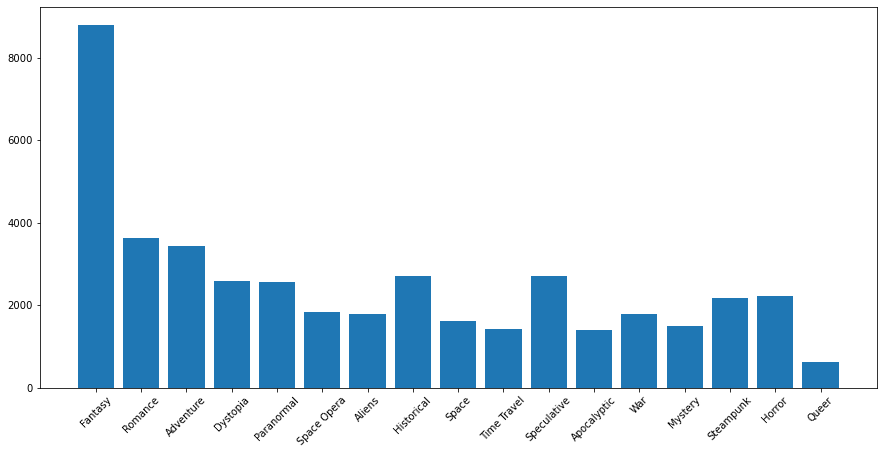

In [72]:
# Visualizes the frequency of each subgenre tag 
plt.figure(figsize=(15,7))
X = df_genre[genre_list].sum().index
y = df_genre[genre_list].sum()
plt.bar(x=X, height=y)
plt.xticks(rotation=45)
plt.title('Frequency of Sub-Genre Tags')
plt.ylabel('Frequency')
plt.xlabel('Sub-Genre')
plt.show()

### Observations

As we can see, this is a fairly evenly balanced genre list with two clear exceptions:

- **Fantasy** - When it comes down to it, Science Fiction can be considered fantasy to many readers, so it makes sense that about 9000 of the 11000 books have a fantasy classification. This means that any more we build will predict fantasy more often than not. This might not be THAT useful to include as a genre, but it could be helpful to writers who want to ground their work in reality and want to *reduce* their fantasy genre score.

- **Queer** - I would argue a lot of books could be considered queer, but aren't by a general audience. I imagine, over time, this category will expand, but it's likely that it will be overlooked by the algorithm in most cases.

## Modeling Genre - Random Forest

When it comes to Multi-Label classification, there aren't a massive number of options for classifiers, so the majority of my focus was on Ensemble Methods, specifically the Random Forest classifier from Sci-Kit Learn. In order to test the various vectorization methods, we have to create new TextSet objects. The only column we are testing is the book description (just like with the Age Model), but the target is now a dataframe, not just a column. I also passed the "multi-label==True" command, to ensure that the target variables are processed correctly.

Once more, I tested multiple vectorization methods on the entire dataset, which you can see below.

In [73]:
# Creates the SpaCy dataset with SpaCy vectorization method
spacy_mstop = TextSet(df_genre['Book_Description'],
                     df_genre[genre_list], 
                     name='SpaCy_mstop', multi_label=True,
                     is_spacy=True)

--- 630.0533187389374 seconds ---


In [74]:
# Creates the best dataset for the Age Model, TF-IDF with 400 features and phrases of length 1 or 2 words
tf_400_2mstop = TextSet(X=df_genre['Book_Description'], 
                 y=df_genre[genre_list],
                 name='tf-idf_400_2',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 622.1829972267151 seconds ---


In [75]:
# Creates a 400 feature TF-IDF dataset that only includes 1 word phrases
tf_400_1mstop = TextSet(df_genre['Book_Description'], 
                 df_genre[genre_list],
                 name='tf-idf_400_1',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 622.322048664093 seconds ---


In [76]:
# Vectorizes each of the datasets based on the intended parameters
spacy_mstop.vectorize()
tf_400_2mstop.vectorize(max_features=400, ngram_range=(1,2))
tf_400_1mstop.vectorize(max_features=400)

In [77]:
# Combines the datasets for entering into the ModelComparison object
data_mstop = [spacy_mstop, tf_400_2mstop, tf_400_1mstop]

### Gridsearch and Tuning

For the Random Forest classifier, if you don't pass any parameters, the classifier can fly off the rails with too many estimators and not enough weight placed on each branch. Therefore, I used the Sci-Kit Learn Gridsearch again. I also scaled all of the vectors using the StandardScaler from sklearn. This process takes a long time, but it is a fairly exhaustive exploration of model parameters and dataset usage.

In [78]:
# The gridsearch that feeds into the ModelComparison object
rf_pipe_genre = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre = {
    'rf__n_estimators': [100, 200], # Decides the number of estimators included in the model. Spacy has 96 columns while TF-IDF has 400
    'rf__criterion' : ['gini','entropy'], # Splits branches based on optimizing either gini or entropy scores
    'rf__max_depth': [25, 50, 75], # Determines how extensive and deep the tree will go. Without this parameter, it will go as deep as possible and leads to overfitting
    'rf__min_samples_split': [2, 5], # Determines the minimum number of samples required to consider a split as appropriate. A higher value means fewer splits
    'rf__min_samples_leaf': [2, 5] # Determines the minimum number of samples that can be in a final leaf. The higher the number, the larger the groupings
}

rf_grid_genre = GridSearchCV(rf_pipe_genre, param_grid=grid_genre, scoring='f1_samples',cv=5) # Target metric to optimize is F1 Sample score
rf_compare_genre = ModelComparison(pipeline=rf_grid_genre, data_list=data_mstop, y_format='multi_label',name='rf_genre_5') # The ModelComparison class with the three datasets passed as well as the multi-label format passed

### Metrics

As you may have noticed, I did not optimize Accuracy on this gridsearch. When it comes to multi-label classifiers, accuracy scores can be misleading. Let's say we have 15 columns and the model guesses 14 columns correctly, but 1 column incorrectly...that will return a 'Negative' value rather than a 'Partial Positive'. This means that the accuracy score will be low for a multi-label problem like this. We do have a number of other metrics to measure the model's performance however:

- **Macro** - There are several ways to slice our core metrics. When we look at Macro, the score is taking the Precision/Recall/F1-Score for each genre at a time and then averaging that equally across all genres.
- **Mirco** - This is similar to Macro, however, it doesn't give each genre the same weight. It measures the individual contributions of each genre to calculate the overall metric. Neither Macro nor Micro is *better* but they give a different understanding of what's happening on a row by row basis
- **F1-Samples** - This calculates the F1-Score for each individual row and then averages them. This is specifically designed for Multi-Label classification
- **Hamming Loss** - This is the most effective replacement for Accuracy Score on multi-label classification. It measures the number of incorrectly attributed labels. The lower the score, the higher the overall accuracy.

Ultimately, I selected **F1-Samples** as the optimized metric because it seems to be the best balance across all of the major metrics. So, with that overview, let's see how the model did!

### What is Good?

With multi-label models, it's much harder to say what 'good' is. As you will see, a lot of the results in the end are subjective, but also useful. I will use this initial model with the three datasets as my baseline to work from to see if we can increase metrics.

In [79]:
rf_compare_genre.fit_models()
rf_compare_genre.score_comparison

SpaCy_mstop finished in 3271.1978089809418 seconds
tf-idf_400_2 finished in 1196.275650024414 seconds
tf-idf_400_1 finished in 1194.1586890220642 seconds
--- 5662.013308763504 seconds to process ---


,SpaCy_mstop Test,tf-idf_400_2 Test,tf-idf_400_1 Test
Accuracy,0.013100,0.037622,0.035942
Precision (Macro),0.302195,0.778495,0.786072
Precision (Micro),0.785547,0.824558,0.830730
Recall (Macro),0.101155,0.199296,0.200397
Recall (Micro),0.260873,0.335124,0.336337
F1 (Micro),0.391675,0.476560,0.478816
F1 (Macro),0.110665,0.272092,0.274833
F1 (Samples),0.375085,0.448149,0.450294
Hamming-Loss,0.184809,0.167895,0.166986


In [80]:
rf_compare_genre.calc_scores(data_type='holdout')
rf_compare_genre.score_comparison

,SpaCy_mstop Holdout,tf-idf_400_2 Holdout,tf-idf_400_1 Holdout
Accuracy,0.019039,0.049864,0.051677
Precision (Macro),0.297912,0.736465,0.735102
Precision (Micro),0.782790,0.826257,0.833147
Recall (Macro),0.107021,0.212808,0.214823
Recall (Micro),0.268699,0.352311,0.354455
F1 (Micro),0.400071,0.493988,0.497326
F1 (Macro),0.117742,0.290495,0.295099
F1 (Samples),0.382771,0.466272,0.469038
Hamming-Loss,0.180417,0.161591,0.160418


### Observations

The differences between TF-IDF and SpaCy vectorizations is obvious. TF-IDF data definitely performed better in every aspect compared to SpaCy. When it comes to whether or not the 1 word phrase the 1 or 2 word phrase vectorizations didn't make a massive difference. As I mentioned above, the overall 'accuracy' score is miserably bad, which is to be expected. However, a Hamming Loss of less than .2 is not too bad! 

## Genre Model - Part 2 - Popular Only

Now that we have an initial baseline of scores to measure against, let's see if we can increase our overall accuracy/lower our Hamming Loss scores. First, let's restrict our data to popular only. I will remove the 25% of rows with the fewest number of reviews. Some of these books are extremely esoteric, or are collections with messy descriptions. Let's see if we can beat a Hamming Loss score of .1604

I was originally going to narrow my dataset to only popular novels, but that is a double edged sword. The best measure of popularity on this dataset would be the number of reviews/scores a book received. That said, this might be a specific edition of a famous novel, also books published in the last year almost certainly would have a popularity disadvantage.

In [81]:
df_genre['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [82]:
df_pop = df_genre[df_genre['Review_number'] >= 55] # Removed the bottom 25% of books based on number of reviews.

In [83]:
# The SpaCy dataset, but with the reduced number of rows
spacy_mstop_p = TextSet(df_pop['Book_Description'], 
                     df_pop[genre_list], 
                     name='SpaCy_mstop', multi_label=True,
                     is_spacy=True)

--- 483.79224586486816 seconds ---


In [84]:
# The TF-IDF dataset with 1-2 word phrases
tf_400_2mstop_p = TextSet(X=df_pop['Book_Description'], 
                 y=df_pop[genre_list],
                 name='tf-idf_400_2',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 481.70191407203674 seconds ---


In [85]:
# The TF-IDF dataset with 1 word phrases
tf_400_1mstop_p = TextSet(df_pop['Book_Description'], 
                 df_pop[genre_list],
                 name='tf-idf_400_1',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 486.6696741580963 seconds ---


In [86]:
# As always, we have to vectorize
spacy_mstop_p.vectorize()
tf_400_2mstop_p.vectorize(max_features=400, ngram_range=(1,2))
tf_400_1mstop_p.vectorize(max_features=400)

In [87]:
# Our new data list
data_mstop_p = [spacy_mstop_p, tf_400_2mstop_p, tf_400_1mstop_p]

In [88]:
# We're using the same gridsearch pipeline to compare against the last results
rf_pipe_genre_p = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50, 75],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 5]
}

rf_grid_genre_p = GridSearchCV(rf_pipe_genre_p, param_grid=grid_genre, scoring='f1_samples',cv=5)
rf_compare_genre_p = ModelComparison(pipeline=rf_grid_genre_p, data_list=data_mstop_p, y_format='multi_label',name='rf_genre_5')

In [89]:
rf_compare_genre_p.fit_models()
rf_compare_genre_p.score_comparison

SpaCy_mstop finished in 2378.7598679065704 seconds
tf-idf_400_2 finished in 910.8403558731079 seconds
tf-idf_400_1 finished in 904.592137336731 seconds
--- 4194.499955892563 seconds to process ---


,SpaCy_mstop Test,tf-idf_400_2 Test,tf-idf_400_1 Test
Accuracy,0.012923,0.040553,0.042335
Precision (Macro),0.337049,0.808658,0.808453
Precision (Micro),0.817664,0.861001,0.858714
Recall (Macro),0.108641,0.229523,0.235643
Recall (Micro),0.278731,0.374987,0.379087
F1 (Micro),0.415741,0.522439,0.525977
F1 (Macro),0.119212,0.310378,0.316248
F1 (Samples),0.411757,0.504137,0.506624
Hamming-Loss,0.190311,0.166536,0.165985


In [90]:
rf_compare_genre_p.calc_scores(data_type='holdout')
rf_compare_genre_p.score_comparison

,SpaCy_mstop Holdout,tf-idf_400_2 Holdout,tf-idf_400_1 Holdout
Accuracy,0.015644,0.031288,0.028881
Precision (Macro),0.281499,0.721212,0.624428
Precision (Micro),0.809563,0.854496,0.855219
Recall (Macro),0.113382,0.210002,0.217455
Recall (Micro),0.277558,0.351894,0.358960
F1 (Micro),0.413387,0.498498,0.505674
F1 (Macro),0.123967,0.280147,0.286796
F1 (Samples),0.408204,0.481065,0.487719
Hamming-Loss,0.197282,0.177320,0.175763


### Observations

Here our holdout Hamming Loss scores are higher than with the full dataset, so there was an overall drop in accuracy. This is interesting because it could be due to 2 things: 1) the smaller dataset will produce weaker results or 2) there popular books are a little harder to fit into genre categories. Let's attempt one final comparison.

## Genre Model - Part 3 - Recent Books

Last, let's see if we can reduce our Hamming Loss by restricting our dataset to books released in the last 10 years. This will almost halve our dataset, which could definitely cause issues. However, let's give it a shot and see what happens.

In [91]:
# Slices the dataframe to only include books released on or after 2010.
df_g_recent = df_genre[df_genre['Year_published'] >= 2010]

In [92]:
len(df_g_recent)

6848

As we can see, this reduces our dataset by 40%, which is not ideal, but let's see if it affects our model's accuracy in a positive way. As always, we have to create our datasets, which will be the same as the previous ones but with the reduced dataframe rows.

In [93]:
spacy_mstop_n = TextSet(df_g_recent['Book_Description'], 
                     df_g_recent[genre_list], 
                     name='SpaCy_mstop', multi_label=True,
                     is_spacy=True)

--- 424.83809900283813 seconds ---


In [94]:
tf_400_2mstop_n = TextSet(X=df_g_recent['Book_Description'], 
                 y=df_g_recent[genre_list],
                 name='tf-idf_400_2',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 427.0953722000122 seconds ---


In [95]:
tf_400_1mstop_n = TextSet(df_g_recent['Book_Description'], 
                 df_g_recent[genre_list],
                 name='tf-idf_400_1',
                 is_spacy=False, multi_label=True, 
                 keep_stopwords=False)

--- 422.80571699142456 seconds ---


In [96]:
data_mstop_n = [spacy_mstop_n, tf_400_2mstop_n, tf_400_1mstop_n]

In [97]:
# And we also need to vectorize
spacy_mstop_n.vectorize()
tf_400_2mstop_n.vectorize(max_features=400, ngram_range=(1,2))
tf_400_1mstop_n.vectorize(max_features=400)

In [98]:
# We are using the same gridsearch as the last few attempts.
rf_pipe_genre_n = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_genre = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50, 75],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 5]
}

rf_grid_genre_n = GridSearchCV(rf_pipe_genre_n, param_grid=grid_genre, scoring='f1_samples',cv=5)
rf_compare_genre_n = ModelComparison(pipeline=rf_grid_genre_n, data_list=data_mstop_n, y_format='multi_label',name='rf_genre_5')

In [99]:
# Let's fit and compare scores
rf_compare_genre_n.fit_models()
rf_compare_genre_n.score_comparison

SpaCy_mstop finished in 1879.7316989898682 seconds
tf-idf_400_2 finished in 758.3343238830566 seconds
tf-idf_400_1 finished in 759.7690949440002 seconds
--- 3398.0786621570587 seconds to process ---


,SpaCy_mstop Test,tf-idf_400_2 Test,tf-idf_400_1 Test
Accuracy,0.016225,0.047052,0.047593
Precision (Macro),0.359448,0.802213,0.799538
Precision (Micro),0.755937,0.801820,0.805058
Recall (Macro),0.114793,0.249161,0.252280
Recall (Micro),0.279670,0.381184,0.382941
F1 (Micro),0.408288,0.516720,0.519007
F1 (Macro),0.122766,0.328360,0.332595
F1 (Samples),0.379619,0.476000,0.479968
Hamming-Loss,0.190787,0.167817,0.167054


In [100]:
# Here we can compare the holdout scores as well
rf_compare_genre_n.calc_scores(data_type='holdout')
rf_compare_genre_n.score_comparison

,SpaCy_mstop Holdout,tf-idf_400_2 Holdout,tf-idf_400_1 Holdout
Accuracy,0.016058,0.030657,0.032117
Precision (Macro),0.209220,0.753390,0.718425
Precision (Micro),0.778744,0.804917,0.807031
Recall (Macro),0.118547,0.232121,0.237778
Recall (Micro),0.292984,0.368957,0.375500
F1 (Micro),0.425779,0.505982,0.512528
F1 (Macro),0.126730,0.308331,0.315416
F1 (Samples),0.396632,0.465277,0.473573
Hamming-Loss,0.186690,0.170202,0.168742


### Observations

This one didn't do too badly! It seems as though there is more commonality between newer books than there is among 'popular' books. That said, the original dataset with all 11k rows was more accurate and produced a slightly better Hamming Loss score. Therefore, our final model will be trained on the full dataset with the TF-IDF vectorization method. As a reminder, here is the frequency plot of that dataset and the word cloud:

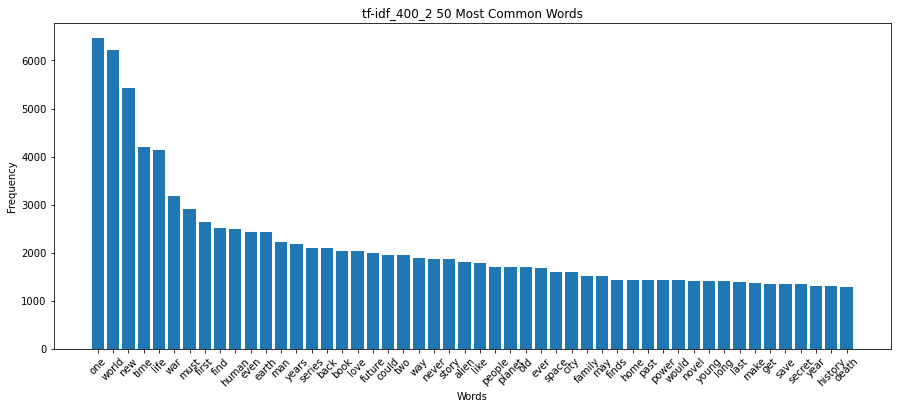

In [101]:
tf_400_2mstop.plot_frequency()

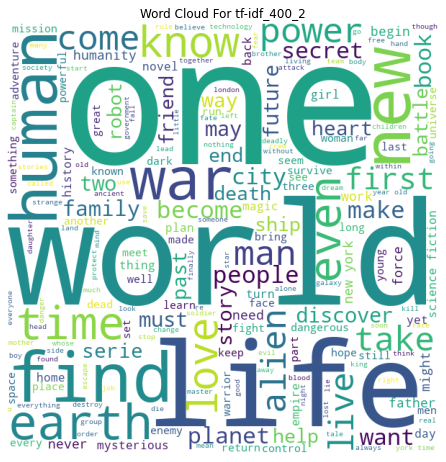

In [102]:
tf_400_2mstop.word_cloud()

We will also save this vectorizer for later transformations

In [103]:
# Saves vectorizer for future use.
genre_vectorizer = tf_400_2mstop.vectorizer

In order to export our final trained model, we need to retrain it only on the best dataset, which is the TF-IDF_400_2 dataset.

In [104]:
rf_pipe_final = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid_final = {
    'rf__n_estimators': [100, 200],
    'rf__criterion' : ['gini','entropy'],
    'rf__max_depth': [25, 50, 75],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 5]
}

rf_grid_final = GridSearchCV(rf_pipe_final, param_grid=grid_final, scoring='f1_samples',cv=5)

rf_compare_final = ModelComparison(
                            pipeline=rf_grid_final, 
                            data_list=[tf_400_2mstop], 
                            y_format='multi_label',
                            name='rf_final')

In [105]:
rf_compare_final.fit_models()
rf_compare_final.all_scores

tf-idf_400_2 finished in 1198.602403640747 seconds
--- 1198.7354109287262 seconds to process ---


,tf-idf_400_2 Train,tf-idf_400_2 Test
Accuracy,0.280346,0.038965
Precision (Macro),0.989416,0.784374
Precision (Micro),0.945551,0.829003
Recall (Macro),0.575053,0.201671
Recall (Micro),0.683982,0.337290
F1 (Micro),0.793774,0.479493
F1 (Macro),0.689561,0.275266
F1 (Samples),0.746391,0.449915
Hamming-Loss,0.081243,0.167006


In [106]:
genre_model = rf_compare_final.pipeline

![Comet](images/comet.jpg)

## Readying the Models for Deployment

Now that we have our age and our genre models, we need to do a few things to create the functions we need to deploy this on Streamlit. I have saved both models to this repo folder for use elsewhere, but before we just start throwing book descriptions into the mix, we have to build a prepocessing pipeline. Also, we want the results of the model's predictions to be informative. Because of this, the actual labels the model spits out won't be as helpful as the ranked probabilities of each genre. This way, an author can increase and decrease their scores by removing and adding specific words.

### A Note on TF-IDF

For any author reading this looking to use it on their own work, please take note that this model does not account for sentence structure, unique words (like proper nouns etc.) but rather just the language that exists in certain descriptions and not in others. Therefore, you could artificially increase your military score by just dumping the words "War", "soldier", "gun" etc. without any context. This model doesn't tell you if your description is GOOD, only what the model believes which genre it belongs to.

### Building a Pre-Processing Pipeline

With any textual input, we need to vectorize the data in exactly the same way we vectorized the text that fed the trained model. The TextSet class that I created stores the vectorization (trained on the entire book description corpus) and we can store that for future use. We must also tokenize the text in the same way using the 'process_text()' function to ensure that we are lemmatizing the words in the same manner as the test data. To do so, we need to build several functions to output results that are helpful to an author. 

Below you can see the create_tf_vector function as well as a print_scores function

In [58]:
def create_tf_vector(description, model='genre'):
    
    '''
    Uses the process_text function to pre-process a book description in order to feed it into the appropriate model.
    
    Parameters
    ----------
    
    description - string - a book description that we want to analyze in the form of a string. May include \n, which will be replaced with blank spaces.
    model - string - "genre", "age" - determines which vectorizer to use, either the age vectorizer or the genre vectorizer
    
    Returns
    -------
    
    A vectorized prepresentation of the text as an numpy array
    
    '''
    
    if model == 'genre':
        vectorizer = genre_vectorizer
    elif model == 'age':
        vectorizer = age_vectorizer
        
    description.replace('\n','') # Removes any superfluous line breaks
    tokens = process_text(description, keep_stopwords=False) # Removes stop words and lemmatizes text
    vector = vectorizer.transform([' '.join(tokens)]) # Turns the tokens into a vector with the appropriate vectorizer
    
    return vector.toarray()

In [59]:
def print_scores(description, mode='genre'):
    
    '''
    Prints the results of either the genre or the age model when a book description is passed through.
    The function preprocesses the description with a vectorizer based on which setting is desired and then
    feeds that vector into either the genre or age model, returning the results as a dataframe with the
    results as probabilities and sorted by value.
    
    Parameters
    ----------
    
    description - string - a book description that we want to analyze in the form of a string. May include \n, which will be replaced with blank spaces.
    model - string - "genre", "age" - determines which vectorizer to use, either the age vectorizer or the genre vectorizer
    
    Returns
    -------
    
    A dataframe of the scores, listed in descending order based on probability
    
    '''
    
    if mode == 'genre':
        labels = genre_list # Uses the list of genres that were used to train the genre model
        model = genre_model
    elif mode == 'age':
        labels = ['Adult', 'Children', 'Young Adult']
        model = age_model
    
    # Vectorizes the description and then creates prediction probabilities
    vector = create_tf_vector(description, model=mode)
    predict = model.predict_proba(vector) 
    
    # Creates score dictionary that will be turned into a dataframe
    score_dict = {}
    
    if mode =='genre':
        for (n, label) in enumerate(labels):
            score_dict[label] = predict[n][0][1] #The outputs of each model's predictions are structured slightly differently
            
    elif mode =='age':
        for (n, label) in enumerate(labels):
            score_dict[label] = predict[0][n]

    # Sorts the dictionary based on score values
    final_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # Turns dictionary into a dataframe
    df = pd.DataFrame.from_dict([final_dict]).T
    
    df.columns = ['Probabilities']
    
    return df

Now that we have both of these, let's test it. I figured the best way to test the effectiveness of the program is to feed in my own work and see what happens! I have three book descriptions along with my thoughts on their age categories as well as their subgenres in the science fiction space.

- **Septimus Salt** - A fantasy novel intended for young adults. Has some romantic elements, but it's mainly a seaborn adventure story.

In [109]:
septimus ='''In Septimus Salt, a boy grows from adolescence and into old age as he attempts 
the impossible: to sail to the moon. Eventually, he is forced to come to terms with the fact that his dreams 
may never come to pass and that he might have thrown his life away chasing a fairy tale. At what point do you 
give up and head back? Or do you just keep sailing into the storm and hope for the best?Septimus Salt follows 
one man’s life, from humble beginnings on the island of Evermore in the Infinite Sea, surrounded by aquaphobes 
and false intellectuals.  He follows in the footsteps of great sailors who attempted and failed before him, 
completely unaware of the myriad dangers that await him in the lonely waters: hunger, thirst, thieves, lost 
love, monsters in the dark, and the sea itself (as well as some goop that turns him into a chicken at one point). 
The story begins in the Young Adult vein of The Little Prince or A Wrinkle in Time but as Septimus ages and 
his adventures grow darker and more sinister, the story falls into the whimsical danger of Ray Bradbury or 
Susanna Clarke.'''

- **Arcadium** - A tense, science-fiction political thriller. Definitely for adults.

In [110]:
arcadium = '''Arcadium I is the science fiction retelling of Shakespeare's Henry IV Part I. 
It tells the story of the ascension of an underestimated ruler by way of brutal violence, self-discovery, 
and strategic brilliance.  Five hundred years after humans have fled a decaying Earth, they have settled 
on two planets in a solar system: the jungle planet Arcadia and an ice planet Avalon. Arcadia, a planet 
plagued with income inequality, terrorist attacks, political strife, and failing infrastructure, is kept 
under the heel of the technologically superior Avalon, forced to send shipments of food every two years 
whenever the planets fall into a similar orbit. If the shipments don't come, Avalon attacks and Avalon 
always wins. Helyn Pilot is second in line for the Arcadian throne. She's brilliant and passionate, 
but utterly under-utilized by her family as a vapid tabloid target. At 22 years old, she is perceived 
as little more than a party girl whose closest relationship is with her drug dealer, the war hero and 
night club owner, Jack Stafford. Her addictions and her reputation destroy her arranged marriage with 
the Avalonian heir and with it, their only chance for peace. In the explosive aftermath, Helyn is thrust 
into the darkest jungles and is forced to fight her way out. Enemies and espionage surround her as she runs 
from terrorist groups and Avalonian agents. Though experiencing serious drug withdrawal, she survives, 
thrives, and manipulates her enemies' misconceptions of her in order to politically and physically 
out-maneuver them at every turn. Arcadium I is the first part of a trilogy that follows the trajectory 
of Shakespeare's Henriad, culminating in the massive and all-out invasion depicted in Henry V.'''

- **Winterland** - An apocalyptic, gory horror story set in Chicago. Very much for adults.

In [111]:
winterland = '''
Kat Dobson is a millennial lost between her loyalty to revolutionary politics and getting her life together 
as she enters her thirties. Newly sober, she takes her yearly pilgrimage to her parents’ home in a wealthy 
suburb of Chicago only to face the brunt of her family’s conservative political views. The first dinner back 
is a drunken, emotional disaster. Afterwards, Kat realizes she’s sitting on the precipice of giving up on all 
of her values for a paycheck. But before she can take the plunge to become someone she isn’t, the world shifts. 
The morning after the dinner, the sun doesn’t come up. The Dobson’s phones and TVs don’t work and the snow 
continues to fall, trapping them all inside her family home. One by one, the members of the Dobson household 
start to fall ill. Panic sets in as the sun fails to rise again, but the true menace of their nightmare is 
what lies in wait beyond their walls: an unrelenting cabal of psychotic hunters, tracking and killing them 
one by one. Winterland follows Kat and the survivors as they flee her parents’ home and strike out into 
apocalyptic Chicago. In the fight for her life, Kat has to wrestle with the knowledge that her entire world 
is gone and the old rules she took for granted are the very things that will kill her. Will she adapt to this 
new reality, or will she succumb to the sickness and become one of the monsters herself?
'''

Let's see how the model does on each of these descriptions!

### Septimus Salt
- Fantasy, Adventure, Romance
- Young Adult

In [112]:
print_scores(septimus, mode='genre')

,Probabilities
Fantasy,0.886850
Romance,0.665305
Paranormal,0.417075
Historical,0.365290
Dystopia,0.298736
Time Travel,0.285788
Adventure,0.269747
Speculative,0.212134
Horror,0.188773
Steampunk,0.161618


In [113]:
print_scores(septimus, mode='age')

,Probabilities
Adult,0.556962
Young Adult,0.334044
Children,0.108994


Not perfect, but it definitely reveals a few things. The Fantasy score is very high, which is good, because Septimus Salt is more fantasy than Science Fiction. Romance scored high, which is also good. It's not a 'romance' novel at its essence but a love story is central to its plot. Paranormal and Historical are both interesting selections, perhaps because sailing is heavily involved. As for age scores, it believes it's adult, but with only 55%, while young adult is definitely up there. Let's try another!

### Arcadium
- Science Fiction, Space, War, Speculative
- Adult

In [114]:
print_scores(arcadium, mode='genre')

,Probabilities
Fantasy,0.791913
Adventure,0.364713
Space Opera,0.362963
Space,0.357648
Aliens,0.329401
War,0.308813
Speculative,0.278885
Dystopia,0.205038
Romance,0.161866
Steampunk,0.152668


In [115]:
print_scores(arcadium, mode='age')

,Probabilities
Adult,0.839645
Young Adult,0.149596
Children,0.010759


Now we can see the differences starting to show. Arcadium is solidly in the 'Adult' category, which is great. It's also cool that it picks up that Arcadium is speculative, because while it is a science-fiction book, it tries to be rooted in reality. Space Opera, Adventure and Space were also high on the list, which makes sense give how much 'space' language I have in the description. Let's attempt our final description:

### Winterland
- Dark Fantasy, Apocalyptic, Horror
- Adult

In [116]:
print_scores(winterland, mode='genre')

,Probabilities
Fantasy,0.748552
Dystopia,0.656224
Apocalyptic,0.600070
Horror,0.510428
Adventure,0.363222
Romance,0.331423
Paranormal,0.223372
Steampunk,0.130586
Mystery,0.122560
War,0.112097


In [117]:
print_scores(winterland, mode='age')

,Probabilities
Adult,0.566544
Young Adult,0.382402
Children,0.051054


These results are also very curious. It definitely latches onto the apocalyptic aspect of the story (which might be cheating because I literally include the word 'apocalyptic' in the description) but it also scores very high on 'Dystopia' which I wouldn't have guessed. Horror also scored high, which is fantastic. As for age scores, at least the model knows this isn't for children, but the Young Adult score is higher than expected.

## Book Similarity

Now that we can identify the genres, let's see if we can find similar books to our description. To do this I will use Sci-Kit Learn's **cosine_similarity** function. I use this because, if the vectorization method I selected is indeed the most effective available, the best way to determine the similarity between two vectors is with the cosine distance. I made this decision after exploring the benefits of cosine distance in building the Skip-Gram algorithm at the core of SpaCy and other word embedding libraries. Fortunately, the computational requirements to evaluate cosine similarity are fairly low.

First, we need to vectorize every book description, which we can do with our vectorizer function:

In [119]:
df_genre['TF_Vector'] = df_genre['Book_Description'].map(lambda x: create_tf_vector(x))

In [121]:
# Creates a slimmer Dataframe which includes all vectorizations of each book description for comparison.
df_vectors = df_genre[[
    'Book_Title',
    'Author_Name', 
    'Year_published', 
    'Book_Description', 
    'TF_Vector',
    'Rating_votes',
    'Review_number',
    'Rating_score',
    'Age_Group']]

And here is the function that does all the work to process and organize the dataframe:

In [52]:
def find_most_similar(description, number=10, year=1900, detail=None):
    
    '''
    Takes a book description, processes it into a vector and returns the most similar books based on the cosine
    similarity of that vector to the other book descriptions. Can return single descriptions or a table of books.
    
    Parameters
    ----------
    
    description - string - a book description that we want to analyze in the form of a string. May include \n, which will be replaced with blank spaces.
    number - int - determines the number of rows returned in the final dataframe
    year - int - restricts the comparisons to books published after a certain date
    detail - None or int - if None is passed, the return will be a dataframe. If an integer is passed, the dataframe will return the details of that row of the returned dataframe
    
    Returns
    -------
    
    A dataframe ordered by the cosine similarity of the book descriptions. If an integer is passed in 'detail'
    then the return will be the dataframe as well as the book description of that row of the dataframe.
    
    '''
    
    df = df_vectors[df_vectors['Year_published'] >= year] # Reduces the final dataframe to only books published after the selected year
    
    vector = create_tf_vector(description, model='genre') #vectorizes your book description with a default to 'genre' 
    
    # We find the cosine similarity score for each vector in the dataframe (computationally expensive)
    df['Similarity'] = df['TF_Vector'].map(lambda x: cosine_similarity(vector, x)[0][0])
    
    # The final dataframe is sorted by similarity scores
    df_final = df.sort_values(by=['Similarity'], ascending=False)
    
    # Drops unwanted columns
    df_final.drop(columns=['TF_Vector'],inplace=True)
    
    if detail == None:
        return df_final.head(number) # If detail is not requested, returns the top 10 rows
    else: #If detail IS requested, it will print off one description for closer inspection
        title = df_final['Book_Title'].iloc[detail]
        author = df_final['Author_Name'].iloc[detail]
        year = df_final['Year_published'].iloc[detail]
        desc = df_final['Book_Description'].iloc[detail]
        
        print(f'''
        Most similar #{detail+1}:
        
        Title: {title}   Author: {author}  Year: {year}
        
        {desc}
        ''')
        return df_final

In [51]:
def most_impactful_words(description, num=None):
    
    '''
    Finds the most impactful words in a description. It vectorizes the description and then sorts the words in terms
    of vector magnitude.
    
    Parameters
    ----------
    
    description - string - the book description that you would like to analyze as a single string
    
    num - int - number of features you would like to see. Defaults to all relevant words. 
                If an integer greater than the number of words is passed, the entire word list is returned.
                
    Returns
    -------
    
    A dataframe showing the words in order of importance
    
    '''
    
    # Vectorizes the description using the genre vectorizer
    vector = create_tf_vector(description)
    # Gets the names of the vector columns which correspond to the 400 most common words in the total corpus
    words = genre_vectorizer.get_feature_names()
    
    # Turns the vector into a dataframe with the words as the index
    df = pd.DataFrame(vector, columns = words).T
    df.columns = ['Value']
    
    # Returns the words ranked in order of score and filters out any words that are not included in the vector
    final_df = df[df['Value'] > 0].sort_values(by='Value', ascending=False)
    
    # Returns the number of words requested, defaults to all
    if (num == None) or (num >= len(final_df)):
        return final_df
    else:
        return final_df.head(num)

Now, simply, we just need to run the vectorized book description against the vectors in the dataset and then order them in terms of similarity. Here's what we find for each book:

In [130]:
find_most_similar(septimus, detail=0)


        Most similar #1:
        
        Title: Clockwork   Author: Philip Pullman  Year: 1996
        
        Fritz, the writer, spins a spine-tingling tale to cheer up Karl, the apprentice clockmaker. But rather than helping matters, the story begins to come true.... The stories of Karl, the apprentice; Dr. Kalmenius, his nefarious “savior”; Gretl, the brave daughter of the town innkeeper; and a young prince whose clockwork heart is in danger of winding down come together in surprising and magical ways in a story that has the relentless urgency of a ticking clock.
        


,Book_Title,Author_Name,Year_published,Book_Description,Rating_votes,Review_number,Rating_score,Age_Group,Similarity
9531,Clockwork,Philip Pullman,1996,"Fritz, the writer, spins a spine-tingling tale...",6753,725,3.87,Children,0.426993
11077,The Lost Prince,Selden Edwards,2012,From the author of the beloved New York Times ...,692,147,3.50,Adult,0.362074
418,Once Upon a Time,Alessandra Hazard,2019,"A very proper prince and a rude, dangerous man...",2395,303,4.31,Adult,0.353124
1235,Devilish Dot,Jaid Black,2004,"Book 6.5 in the Trek Mi Q'an Series. Dorothy ""...",1004,28,3.64,Adult,0.349213
867,From a Distant Star,Karen McQuestion,2015,Seventeen-year-old Emma was the only one who h...,2422,532,3.88,Young Adult,0.339531
...,...,...,...,...,...,...,...,...,...
7256,Ghost,John Ringo,2005,Retired after 15 years in special ops due to a...,4093,218,3.88,Adult,0.000000
7254,Pandora's Legions,Christopher Anvil,2002,The mighty Centran Empire had been conquering ...,1194,28,3.69,Adult,0.000000
1564,Grantville Gazette III,Eric Flint,2006,Stories include:* Postage Due by Eric Flint* P...,604,19,3.72,Adult,0.000000
8915,Return of the Jedi,James Kahn,1983,Der letzte Teil der Star Wars Saga erzählt die...,9251,260,4.06,Adult,0.000000


When this first description came back, I was super excited. Not only is Philip Pullman one of my favorite authors of all time, but *Clockwork* doesn't seem to have a direct link to *Septimus Salt* but both share a whimsical, magical and dark tone. That is exactly the kind of the connection I'm looking to build with this program. I don't want a carbon copy of some kid sailing a lot, I'm looking for tonal and thematic similarities instead.

Again, this is not machine learning, though it is vectorized based on training a machine learning model. This is not meant to be a definitive link between two books, but it's intended to help in the search for similar authors and books, which can be valuable to any new author.

![pandora](images/pandora.jpeg)

# Conclusion

These two models could be extremely helpful to new science fiction authors in trying to refine and improve their book descriptions. It could also help them identify other similar books and authors to help young writers research possible agents to submit their work to. There are many uses for this information, but the program has many shortcomings in terms of assessing 'successful' descriptions. Here are the two main use cases for a possible science fiction book:

## Use Case 1 - Refine Description

As you saw before, my description of Arcadium received the following scores and important words:

In [131]:
print_scores(arcadium, mode='genre')

,Probabilities
Fantasy,0.791913
Adventure,0.364713
Space Opera,0.362963
Space,0.357648
Aliens,0.329401
War,0.308813
Speculative,0.278885
Dystopia,0.205038
Romance,0.161866
Steampunk,0.152668


In [132]:
print_scores(arcadium, mode='age')

,Probabilities
Adult,0.839645
Young Adult,0.149596
Children,0.010759


In [144]:
most_impactful_words(arcadium, 10)

,Value
planet,0.281074
political,0.267651
two,0.257302
years,0.247894
forced,0.234755
enemies,0.234265
part,0.233458
every,0.200372
way,0.171648
jack,0.144536


This is actually an old book description for a previous draft. After rewriting the book, with several character and thematic shifts, I created a new book description:

In [47]:
arcadium_2 = '''
Nobody has ever taken Helyn Pilot seriously. As the daughter of the ruling family on the planet of Arcadia, 
humanity’s second to last hope to avoid extinction, she wastes away her days partying with her drug dealer and 
avoiding the paparazzi. Far more intelligent than her brother, the heir to the throne, she knows she is destined 
for more than to be married off to the rulers of their enemy, the ice planet Avalon. When her mistakes split 
her family at the core and ruin any hope for peace between the two warring planets, sheltered and inexperienced 
Helyn finds herself marooned and lost in the jungle, fighting for her life against the elements and the 
army of Avalonian agents hunting her down. Helyn isn’t alone, protected by one of the only Arcadian soldiers who knows 
how to navigate the dangers of the wilderness. If Helyn hopes to survive and become the leader she 
knows she was born to be, she needs to use every ounce of her strategic brilliance and to call into question 
the entire life she has been given on a silver platter. Will she step up? Or will she break? Arcadium is first 
part of a science fiction trilogy that retells the story of Shakespeare’s Henry V and shows that the unlikeliest 
of leaders are sometimes the ones we need most.
'''

Let us see how this new description scores:

In [146]:
print_scores(arcadium_2, mode='genre')

,Probabilities
Fantasy,0.788611
Romance,0.359704
Speculative,0.290490
Adventure,0.287620
Dystopia,0.280270
Space Opera,0.276021
Aliens,0.271481
Space,0.246738
War,0.223977
Paranormal,0.183141


In [147]:
print_scores(arcadium_2, mode='age')

,Probabilities
Adult,0.573850
Young Adult,0.352897
Children,0.073253


In [149]:
most_impactful_words(arcadium_2, 10)

,Value
knows,0.364095
hope,0.266276
family,0.231359
planet,0.227306
life,0.164655
trilogy,0.163214
question,0.160813
peace,0.159670
born,0.158875
taken,0.158718


Here we see that a few categories have actually increased that maybe I wanted to reduce. For example, Romance is much higher on the rankings and *Arcadium* is absolutely not a romance story. Also, the adult score has dropped too, so maybe I made this look a little more like a young adult novel. So, the rewrite wasn't necessarily the obvious direction that I wanted to take.

How to turn this into actionable insights? I will discuss that in the "Next Steps" section coming up.

## Use Case 2 - Similar Books

The second use case is finding similar books and authors. With the find_most_similar function, we can restrict the books returned from the database to only books from the last 5-10 years. From there, an author can decide if the descriptions are thematically or tonally similar and then research those authors, their books, and, most crucially, their agents. This is all purely subjective in terms of how 

Here is the new Arcadium's similarity information:

In [61]:
find_most_similar(arcadium_2, year=2010)

,Book_Title,Author_Name,Year_published,Book_Description,Rating_votes,Review_number,Rating_score,Age_Group,Similarity
597,Provenance,Ann Leckie,2017,An ambitious young woman has just one chance t...,14537,1741,3.83,Adult,0.322633
5389,Archangel,William Gibson,2017,Science Fiction Superstar William Gibson's fir...,1013,169,3.38,Adult,0.311967
414,Born of Silence,Sherrilyn Kenyon,2012,\nDeath Stalks Them All...\nKere is the second...,11105,762,4.48,Adult,0.309683
4929,KOP Killer,Warren Hammond,2012,"KOP Killer, a darkly dystopian science fiction...",311,34,3.81,Adult,0.303490
4375,Arclight,Josin L. McQuein,2013,No one crosses the wall of light . . . except ...,4195,544,3.60,Young Adult,0.303448
685,Cloak and Silence,Sherrilyn Kenyon,2013,Every Life Has A Price™One of the fiercest sol...,6616,472,4.31,Adult,0.298943
8995,The Terrans,Jean Johnson,2015,Jean Johnson's first novel in an explosive new...,860,109,3.96,Adult,0.283993
7285,Libre,S.H. Jucha,2015,The saga of the Rêveur continues in this secon...,2388,130,4.09,Adult,0.278296
5878,Shutdown,Heather Anastasiu,2013,"The battle is all but over, and hope seems to ...",1767,176,4.10,Young Adult,0.277769
7321,Do Unto Others,Michael Z. Williamson,2010,Do Unto Others as They Did Unto You—the Code o...,540,15,4.02,Adult,0.274018


In [161]:
df = find_most_similar(arcadium_2, detail=1)


        Most similar #2:
        
        Title: Provenance   Author: Ann Leckie  Year: 2017
        
        An ambitious young woman has just one chance to secure her future and reclaim her family's priceless lost artifacts in this stand-alone novel set in the world of Ann Leckie's groundbreaking, NYT bestselling Imperial Radch trilogy, which won the Hugo and Nebula awards.NOMINATED FOR THE HUGO AWARD FOR BEST NOVEL 2018NOMINATED FOR THE LOCUS AWARD FOR BEST SCIENCE FICTION NOVEL 2018Though she knows her brother holds her mother's favor, Ingrid is determined to at least be considered as heir to the family name. She hatches an audacious plan--free a thief from a prison planet from which no one has ever returned, and use them to help steal back a priceless artifact.But Ingray and her charge return to her home to find their planet in political turmoil, at the heart of an escalating interstellar conflict. Together, they must make a new plan to salvage Ingray's future and her world, befo

Curiously, though the genre scores changed fairly dramatically, the recommended similar books list is almost the same as the original Arcadium list. This means that, while the overall scores can change quite easily, the recommendations are a little more robust, which is really cool. Whether or not that's a good thing, I need to test further to see.

## Further Exploration

As I mentioned in the beginning, this tool is powerful, but it could use more work. The core dataset is comprised only of Science Fiction books, but, with more data from other genres, we could build different models for each genre as well as expand our similarity database to further aid authors in exploring other agents.

Beyond that, this same methodology could be used to try to predict a novel's success based on its description, though that would require book sales data. This data definitely exists, but because it is so valuable to the publishing industry, it is supremely expensive.

Lastly, this data does not include one crucial column: Agents. If we enriched the data with the agents who represent the books, we can start to see patterns in agent tastes and preferences. Again, finding that data can be a challenge/expensive, but it would increase the value of this tool immeasurably.

I plan to continue working on this model by expanding the number of genres as well as the size of the overall dataset. If I can fold in direct agent information to create new insights, that would be the ultimate goal.

### Novel Nexus Streamlit App

As for deployment I have a number of features and objectives I want to include for new authors. My app lives in this GitHub repo, so feel free to explore it. Here are the current goals for the app:

- Allow authors to upload and score a book description based on genre and age groups
- Print out 10 most similar books with the ability to drill into individual book descriptions
- Allow authors to upload a second book description (a different book or a second draft) and see the difference in genre and age scores
- Compare the vector values based on the words measured in each description to see which words contribute to the differences
- Be able to measure a book description's similarity to the average vector of the author's desired genres so they know which words to remove and which to add in to change scores
- See a highlighted presentation of the description with the measured/important words highlighted

I will continue to work on this app over time with more updates to make it as useful to non-technical authors as much as possible.

## Resources

### Writing Resources
- [How to Write a Query Letter](https://www.janefriedman.com/query-letters/)
- [Determing Sci-Fi Sub-Genres](https://writersrelief.com/2011/07/11/determine-book-genre/)
- [Writing a Science Fiction Cover Letter](https://writersrelief.com/2018/05/31/query-letter-genre-essentials-pitching-sci-fi-and-fantasy-novels-writers-relief/)

### NLP Resources
- [How SpaCy Words](https://spacy.io/usage/spacy-101)
- [TF-IDF Vectorization - Towards Data Science Blog](https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d)
- [Skip-Grams - Towards Data Science Blog](https://towardsdatascience.com/skip-gram-nlp-context-words-prediction-algorithm-5bbf34f84e0c)
- [SpaCy Lemmatizer Documentation](https://spacy.io/api/lemmatizer)
- [Multi-Label Classification Metrics - Towards Data Science Blog](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)
